In [1]:
import numpy as np
from keras.models import Model
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras import layers
from keras.utils import load_img, img_to_array
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
init = RandomNormal(stddev= 0.02)

In [3]:
def create_discriminator(img_shape):
    in_src_img = layers.Input(img_shape)
    in_target_img = layers.Input(img_shape)
    
    merged = layers.Concatenate()([in_src_img, in_target_img])
    
    d = layers.Conv2D(64, 4, strides= 2, padding= 'same', kernel_initializer= init)(merged)
    d = layers.LeakyReLU(alpha= 0.2)(d)
    
    d = layers.Conv2D(128, 4, strides= 2, padding= 'same', kernel_initializer= init)(d)
    d = layers.BatchNormalization()(d)
    d = layers.LeakyReLU(alpha= 0.2)(d)
    
    d = layers.Conv2D(256, 4, strides= 2, padding= 'same', kernel_initializer= init)(d)
    d = layers.BatchNormalization()(d)
    d = layers.LeakyReLU(alpha= 0.2)(d)
    
    d = layers.Conv2D(512, 4, strides= 2, padding= 'same', kernel_initializer= init)(d)
    d = layers.BatchNormalization()(d)
    d = layers.LeakyReLU(alpha= 0.2)(d)
    
    d = layers.Conv2D(512, 4, padding= 'same', kernel_initializer= init)(d)
    d = layers.BatchNormalization()(d)
    d = layers.LeakyReLU(alpha= 0.2)(d)
    
    d = layers.Conv2D(1, 4, padding= 'same', kernel_initializer= init)(d)
    d = layers.Activation('sigmoid')(d)
    
    model = Model([in_src_img, in_target_img], d)
    
    opt = Adam(0.0002, 0.5)
    model.compile(opt, loss= 'binary_crossentropy', loss_weights= [0.5])
    
    return model

In [4]:
def encoder(layer_in, n_filters, batch_norm= True):
    g = layers.Conv2D(n_filters, 4, strides= 2, padding= 'same', kernel_initializer= init)(layer_in)
    res = layers.Conv2D(n_filters, 1, strides= 2, padding= 'same', kernel_initializer= init)(layer_in)
    if batch_norm:
        g = layers.BatchNormalization()(g, training= True)
        res = layers.BatchNormalization()(res, training= True)
    g = layers.add([g, res])
    g = layers.LeakyReLU(alpha= 0.2)(g)        
    return g

In [5]:
def decoder(layer_in, skip_in, n_filters, dropout= True):
    g = layers.Conv2DTranspose(n_filters, 4, strides= 2, padding= 'same', kernel_initializer= init)(layer_in)
    g = layers.BatchNormalization()(g, training= True)
    if dropout:
        g = layers.Dropout(0.5)(g, training= True)
    g = layers.Concatenate()([g, skip_in])
    g = layers.Activation('relu')(g)
    return g

In [6]:
def create_generator(img_shape= (256, 256, 3)):
    in_img = layers.Input(img_shape)
    
    e1 = encoder(in_img, 64, batch_norm= False)
    e2 = encoder(e1, 128)
    e3 = encoder(e2, 256)
    e4 = encoder(e3, 512)
    e5 = encoder(e4, 512)
    e6 = encoder(e5, 512)
    e7 = encoder(e6, 512)
    
    b = layers.Conv2D(512, 4, strides= 2, padding='same', kernel_initializer=init)(e7)
    b = layers.Activation('relu')(b)
    
    d1 = decoder(b, e7, 512)
    d2 = decoder(d1, e6, 512)
    d3 = decoder(d2, e5, 512)
    d4 = decoder(d3, e4, 512, dropout= False)
    d5 = decoder(d4, e3, 256, dropout= False)
    d6 = decoder(d5, e2, 128, dropout= False)
    d7 = decoder(d6, e1, 64, dropout= False)
    
    out_img = layers.Conv2DTranspose(img_shape[2], 4, strides= 2, padding= 'same', kernel_initializer= init)(d7)
    out_img = layers.Activation('tanh')(out_img)
    
    model = Model(in_img, out_img)
    return model

In [7]:
def create_gan(generator, discriminator, img_shape):
    
    for layer in discriminator.layers:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = False
    
    in_src = layers.Input(img_shape)
    
    gen_out = generator(in_src)
    dis_out = discriminator([in_src, gen_out])
    
    model = Model(in_src, [dis_out, gen_out])
    
    opt = Adam(0.0002, 0.5)
    model.compile(opt, loss= ['binary_crossentropy', 'mae'], loss_weights= [1, 100])
    return model

In [8]:
def gen_real_samples(dataset, n_samples, patch_shape):
    trainA, trainB = dataset
    idx = np.random.randint(0, trainA.shape[0], n_samples)
    X1, X2 = trainA[idx], trainB[idx]
    
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    
    return [X1, X2], y

In [9]:
def gen_fake_samples(generator, samples, patch_shape):
    X = generator.predict(samples)
    y = np.zeros((len(X), patch_shape, patch_shape, 1))
    
    return X, y

In [10]:
def performance(step, generator, dataset, n_samples= 3):
    [X_real_A, X_real_B], _ = gen_real_samples(dataset, n_samples, 1)
    X_fake_B, _ = gen_fake_samples(generator, X_real_A, 1)
    
    X_real_A = (X_real_A + 1)/2.0
    X_real_B = (X_real_B + 1)/2.0
    X_fake_B = (X_fake_B + 1)/2.0
    
    for i in range(n_samples):
        plt.subplot(3, n_samples, i + 1)
        plt.axis('off')
        plt.imshow(X_real_A[i])
    for i in range(n_samples):
        plt.subplot(3, n_samples, i + 1)
        plt.axis('off')
        plt.imshow(X_real_B[i])
    for i in range(n_samples):
        plt.subplot(3, n_samples, i + 1)
        plt.axis('off')
        plt.imshow(X_fake_B[i])
    plt.show()

In [11]:
def train(generator, discriminator, gan, dataset, epochs= 100, batch= 1):
    n_patch = discriminator.output_shape[1]
    
    trainA, trainB = dataset
    
    batch_per_epoch = int(len(trainA)/batch)
    n_steps = batch_per_epoch * epochs
    
    for i in range(n_steps):
        [X_realA, X_realB], y_real = gen_real_samples(dataset, batch, n_patch)
        X_fakeB, y_fake = gen_fake_samples(generator, X_realA, n_patch)
        
        d_loss1 = discriminator.train_on_batch([X_realA, X_realB], y_real)
        d_loss2 = discriminator.train_on_batch([X_realA, X_fakeB], y_fake)
        
        g_loss, _, _ = gan.train_on_batch(X_realA, [y_real, X_realB])
        
        print(f'dl1 : {d_loss1}, dl2 : {d_loss2}, gl: {g_loss}')
        
        if (i + 1) % (batch_per_epoch * 10) == 0:
            performance(i, generator, dataset)

In [12]:
img_sample = mpimg.imread('/kaggle/input/edge2shoes/edges2shoes/train/1001_AB.jpg')

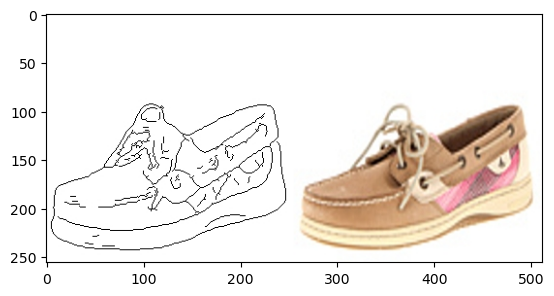

In [13]:
plt.imshow(img_sample)
plt.show()

In [14]:
def get_images(path, img_shape= (256, 512)):
    src_list, tar_list = list(), list()
    
    # Get 10 images else training will take forever
    count = 0
    for f in glob.glob(path):
        if count == 10:
            break
        pxl = load_img(f, target_size= img_shape)
        pxl = img_to_array(pxl)
        
        scape_img, mask_img = pxl[:, :256], pxl[:, 256:]
        
        src_list.append(scape_img)
        tar_list.append(mask_img)
        
        count += 1
        
    return[np.asarray(src_list), np.asarray(tar_list)]

In [15]:
path = '/kaggle/input/edge2shoes/edges2shoes/train/*.jpg'

In [16]:
[src, tar] = get_images(path)

In [17]:
src.shape, tar.shape

((10, 256, 256, 3), (10, 256, 256, 3))

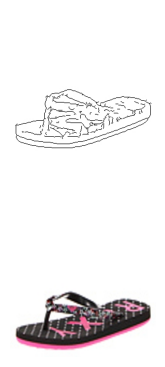

In [18]:
plt.subplot(2, 3, 1)
plt.axis('off')
plt.imshow(src[0].astype('uint8'))

plt.subplot(2, 3, 4)
plt.axis('off')
plt.imshow(tar[0].astype('uint8'))

plt.show()

In [19]:
def proc(data):
    X1, X2 = data[0], data[1]
    
    X1 = (X1 - 127.5)/127.5
    X2 = (X2 - 127.5)/127.5
    
    return [X1, X2]

In [20]:
data = [src, tar]
dataset = proc(data)

In [21]:
img_shape = src.shape[1:]

In [22]:
generator = create_generator(img_shape)
generator.summary()

/opt/conda/lib/python3.10/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  3136        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  256         ['input_1[0][0]']                
                                )                                                             

In [23]:
discriminator = create_discriminator(img_shape)
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 6)  0           ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

In [24]:
gan = create_gan(generator, discriminator, img_shape)
gan.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 256, 256, 3)  55400195    ['input_4[0][0]']                
                                                                                                  
 model_1 (Functional)           (None, 16, 16, 1)    6968257     ['input_4[0][0]',                
                                                                  'model[0][0]']                  
                                                                                            

2023-07-27 12:56:39.490160: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 6s 6s/step


2023-07-27 12:56:53.905039: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/model/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


dl1 : 0.40742623805999756, dl2 : 0.6402323246002197, gl: 87.64476776123047
1/1 [==============================] - 0s 22ms/step
dl1 : 0.5197029113769531, dl2 : 0.7889592051506042, gl: 85.12488555908203
1/1 [==============================] - 0s 23ms/step
dl1 : 0.5046780109405518, dl2 : 0.6295635104179382, gl: 73.36125183105469
1/1 [==============================] - 0s 23ms/step
dl1 : 0.34979161620140076, dl2 : 0.42787742614746094, gl: 78.6380844116211
1/1 [==============================] - 0s 22ms/step
dl1 : 0.33208441734313965, dl2 : 0.4780580699443817, gl: 78.83444213867188
1/1 [==============================] - 0s 22ms/step
dl1 : 0.4883301258087158, dl2 : 0.683090090751648, gl: 75.75325775146484
1/1 [==============================] - 0s 22ms/step
dl1 : 0.4970625340938568, dl2 : 0.5153071284294128, gl: 72.10848999023438
1/1 [==============================] - 0s 24ms/step
dl1 : 0.4249877333641052, dl2 : 0.4115564227104187, gl: 68.30866241455078
1/1 [==============================] - 0s 

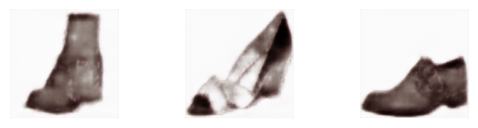

1/1 [==============================] - 0s 22ms/step
dl1 : 0.8772830963134766, dl2 : 0.5262323021888733, gl: 15.998373031616211
1/1 [==============================] - 0s 20ms/step
dl1 : 0.1597050428390503, dl2 : 0.34729281067848206, gl: 27.050939559936523
1/1 [==============================] - 0s 21ms/step
dl1 : 0.17535363137722015, dl2 : 0.23622427880764008, gl: 16.083585739135742
1/1 [==============================] - 0s 23ms/step
dl1 : 0.3660649061203003, dl2 : 0.32091420888900757, gl: 14.012994766235352
1/1 [==============================] - 0s 21ms/step
dl1 : 0.3051998019218445, dl2 : 0.2433813065290451, gl: 13.634416580200195
1/1 [==============================] - 0s 23ms/step
dl1 : 0.1978784054517746, dl2 : 0.12232723832130432, gl: 25.263813018798828
1/1 [==============================] - 0s 22ms/step
dl1 : 0.3906780481338501, dl2 : 0.4781472682952881, gl: 12.731093406677246
1/1 [==============================] - 0s 21ms/step
dl1 : 0.12179116904735565, dl2 : 0.09334437549114227, 

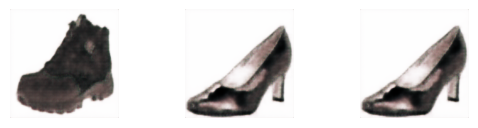

1/1 [==============================] - 0s 22ms/step
dl1 : 0.04507283493876457, dl2 : 0.041727472096681595, gl: 19.24229621887207
1/1 [==============================] - 0s 20ms/step
dl1 : 0.47872796654701233, dl2 : 0.4863736927509308, gl: 5.788907527923584
1/1 [==============================] - 0s 22ms/step
dl1 : 0.2670251429080963, dl2 : 0.4658735394477844, gl: 5.691044807434082
1/1 [==============================] - 0s 22ms/step
dl1 : 0.34997624158859253, dl2 : 0.285007506608963, gl: 8.15044116973877
1/1 [==============================] - 0s 20ms/step
dl1 : 0.016666188836097717, dl2 : 0.0777406096458435, gl: 21.556472778320312
1/1 [==============================] - 0s 22ms/step
dl1 : 0.06614939123392105, dl2 : 0.030890975147485733, gl: 19.372844696044922
1/1 [==============================] - 0s 26ms/step
dl1 : 0.5828061103820801, dl2 : 0.33209964632987976, gl: 5.656771183013916
1/1 [==============================] - 0s 22ms/step
dl1 : 0.02547617256641388, dl2 : 0.06209629774093628, g

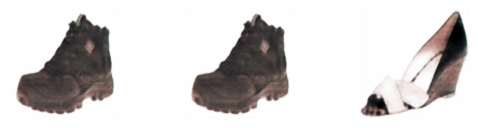

1/1 [==============================] - 0s 48ms/step
dl1 : 0.37213823199272156, dl2 : 0.4089100956916809, gl: 4.696169853210449
1/1 [==============================] - 0s 21ms/step
dl1 : 0.3291080594062805, dl2 : 0.3817102313041687, gl: 4.323843002319336
1/1 [==============================] - 0s 20ms/step
dl1 : 0.14094245433807373, dl2 : 0.13588331639766693, gl: 10.754393577575684
1/1 [==============================] - 0s 19ms/step
dl1 : 0.08820798248052597, dl2 : 0.114040307700634, gl: 17.348726272583008
1/1 [==============================] - 0s 22ms/step
dl1 : 0.08327942341566086, dl2 : 0.10122896730899811, gl: 16.379140853881836
1/1 [==============================] - 0s 22ms/step
dl1 : 0.6560136079788208, dl2 : 0.29014432430267334, gl: 8.881940841674805
1/1 [==============================] - 0s 23ms/step
dl1 : 0.3409351408481598, dl2 : 0.4276100993156433, gl: 10.16662311553955
1/1 [==============================] - 0s 22ms/step
dl1 : 0.3148233890533447, dl2 : 0.4692832827568054, gl: 5

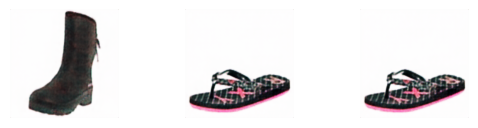

1/1 [==============================] - 0s 25ms/step
dl1 : 0.4533206522464752, dl2 : 0.38311317563056946, gl: 6.099289894104004
1/1 [==============================] - 0s 24ms/step
dl1 : 0.45214468240737915, dl2 : 0.41846999526023865, gl: 6.038064956665039
1/1 [==============================] - 0s 26ms/step
dl1 : 0.26524439454078674, dl2 : 0.41153645515441895, gl: 8.46446418762207
1/1 [==============================] - 0s 25ms/step
dl1 : 0.05766282230615616, dl2 : 0.1472657471895218, gl: 15.389274597167969
1/1 [==============================] - 0s 25ms/step
dl1 : 0.47668612003326416, dl2 : 0.33495032787323, gl: 4.445648670196533
1/1 [==============================] - 0s 25ms/step
dl1 : 0.33022168278694153, dl2 : 0.4257301986217499, gl: 5.707003116607666
1/1 [==============================] - 0s 26ms/step
dl1 : 0.42301812767982483, dl2 : 0.3127013146877289, gl: 5.963571548461914
1/1 [==============================] - 0s 24ms/step
dl1 : 0.17309050261974335, dl2 : 0.1897089183330536, gl: 9.

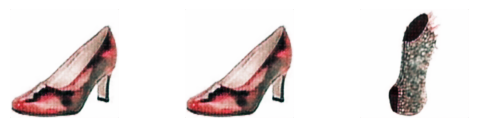

1/1 [==============================] - 0s 21ms/step
dl1 : 0.3500426709651947, dl2 : 0.3874741196632385, gl: 4.537353992462158
1/1 [==============================] - 0s 20ms/step
dl1 : 0.36001646518707275, dl2 : 0.3218928277492523, gl: 5.549123764038086
1/1 [==============================] - 0s 25ms/step
dl1 : 0.02676803059875965, dl2 : 0.24915145337581635, gl: 8.032763481140137
1/1 [==============================] - 0s 21ms/step
dl1 : 0.9443947076797485, dl2 : 0.16581739485263824, gl: 7.790581703186035
1/1 [==============================] - 0s 20ms/step
dl1 : 0.34360548853874207, dl2 : 0.4644339382648468, gl: 3.725353479385376
1/1 [==============================] - 0s 21ms/step
dl1 : 0.45984551310539246, dl2 : 0.3543613851070404, gl: 5.203940391540527
1/1 [==============================] - 0s 20ms/step
dl1 : 0.24322225153446198, dl2 : 0.42008399963378906, gl: 4.415648937225342
1/1 [==============================] - 0s 21ms/step
dl1 : 0.06095098704099655, dl2 : 0.1122991144657135, gl: 1

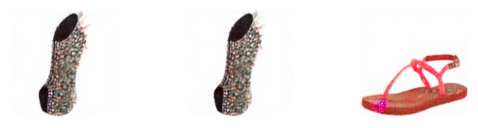

1/1 [==============================] - 0s 21ms/step
dl1 : 0.03859888017177582, dl2 : 0.0938914492726326, gl: 14.632059097290039
1/1 [==============================] - 0s 20ms/step
dl1 : 0.4807782769203186, dl2 : 0.40868592262268066, gl: 3.5973849296569824
1/1 [==============================] - 0s 21ms/step
dl1 : 0.31086963415145874, dl2 : 0.20604990422725677, gl: 5.832762718200684
1/1 [==============================] - 0s 22ms/step
dl1 : 0.24883751571178436, dl2 : 0.41182997822761536, gl: 4.437671661376953
1/1 [==============================] - 0s 41ms/step
dl1 : 0.03623265027999878, dl2 : 0.12686200439929962, gl: 15.379364013671875
1/1 [==============================] - 0s 21ms/step
dl1 : 0.5155653953552246, dl2 : 0.3392360806465149, gl: 3.461930274963379
1/1 [==============================] - 0s 25ms/step
dl1 : 0.17294499278068542, dl2 : 0.16300271451473236, gl: 12.807063102722168
1/1 [==============================] - 0s 23ms/step
dl1 : 0.41815799474716187, dl2 : 0.4450209140777588,

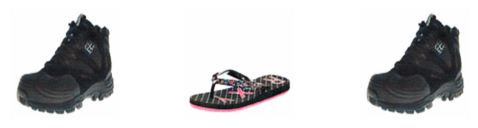

1/1 [==============================] - 0s 25ms/step
dl1 : 0.5204641222953796, dl2 : 0.29961127042770386, gl: 6.088620185852051
1/1 [==============================] - 0s 20ms/step
dl1 : 0.5339024066925049, dl2 : 0.3382244408130646, gl: 10.149105072021484
1/1 [==============================] - 0s 22ms/step
dl1 : 0.281482994556427, dl2 : 0.44141513109207153, gl: 3.7235803604125977
1/1 [==============================] - 0s 23ms/step
dl1 : 0.27286964654922485, dl2 : 0.4014972746372223, gl: 3.434746026992798
1/1 [==============================] - 0s 22ms/step
dl1 : 0.3074378967285156, dl2 : 0.3287048637866974, gl: 3.537262201309204
1/1 [==============================] - 0s 22ms/step
dl1 : 0.3844178318977356, dl2 : 0.34783944487571716, gl: 4.048417568206787
1/1 [==============================] - 0s 23ms/step
dl1 : 0.2173195779323578, dl2 : 0.30524468421936035, gl: 11.260727882385254
1/1 [==============================] - 0s 22ms/step
dl1 : 0.5085293650627136, dl2 : 0.2788355052471161, gl: 7.3

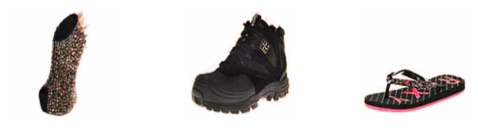

1/1 [==============================] - 0s 23ms/step
dl1 : 0.335580050945282, dl2 : 0.4684658646583557, gl: 7.988229751586914
1/1 [==============================] - 0s 20ms/step
dl1 : 0.3297894597053528, dl2 : 0.5297815203666687, gl: 3.2300236225128174
1/1 [==============================] - 0s 22ms/step
dl1 : 0.2767701745033264, dl2 : 0.39181825518608093, gl: 3.4105257987976074
1/1 [==============================] - 0s 22ms/step
dl1 : 0.32285478711128235, dl2 : 0.43289807438850403, gl: 6.305258750915527
1/1 [==============================] - 0s 22ms/step
dl1 : 0.5373027324676514, dl2 : 0.28285497426986694, gl: 3.1234397888183594
1/1 [==============================] - 0s 21ms/step
dl1 : 0.3593108654022217, dl2 : 0.3706761598587036, gl: 5.280195713043213
1/1 [==============================] - 0s 23ms/step
dl1 : 0.37308672070503235, dl2 : 0.3575429916381836, gl: 3.2001280784606934
1/1 [==============================] - 0s 23ms/step
dl1 : 0.19779744744300842, dl2 : 0.2299199253320694, gl: 1

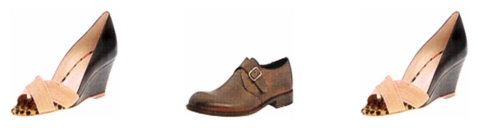

1/1 [==============================] - 0s 21ms/step
dl1 : 0.4350293278694153, dl2 : 0.4509884715080261, gl: 3.2040443420410156
1/1 [==============================] - 0s 20ms/step
dl1 : 0.3382207155227661, dl2 : 0.40653449296951294, gl: 4.589289665222168
1/1 [==============================] - 0s 22ms/step
dl1 : 0.45648372173309326, dl2 : 0.323056697845459, gl: 2.9663236141204834
1/1 [==============================] - 0s 21ms/step
dl1 : 0.3891465365886688, dl2 : 0.39329761266708374, gl: 4.476632595062256
1/1 [==============================] - 0s 21ms/step
dl1 : 0.3720013201236725, dl2 : 0.39094939827919006, gl: 3.175534963607788
1/1 [==============================] - 0s 22ms/step
dl1 : 0.3361221253871918, dl2 : 0.3254094123840332, gl: 3.419782876968384
1/1 [==============================] - 0s 20ms/step
dl1 : 0.22234117984771729, dl2 : 0.2544347643852234, gl: 5.844366073608398
1/1 [==============================] - 0s 24ms/step
dl1 : 0.3601395785808563, dl2 : 0.3504132926464081, gl: 4.31

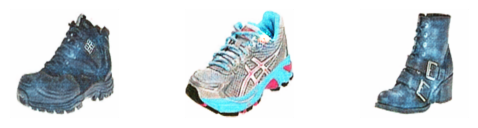

In [25]:
train(generator, discriminator, gan, dataset, epochs= 100)

In [26]:
def plot_images(src, gen):
    images = np.vstack((src, gen))  
    images = (images + 1)/2.0
    
    titles = ['Source', 'Generated', 'Expected']
    
    for i in range(len(images)):
        plt.subplot(1, 2, i + 1)
        plt.axis('off')
        plt.imshow(images[i])
        plt.title(titles[i])
    plt.show()

1/1 [==============================] - 0s 22ms/step


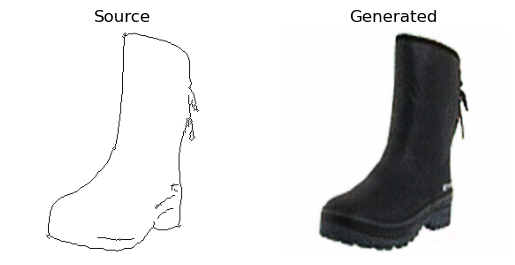

In [27]:
[X1, X2] = dataset
idx = np.random.randint(0, len(X1), 1)

src, tar = X1[idx], X2[idx]
gen = generator.predict(src)

plot_images(src, gen)